Analysis of the Coalescent Simulation
=====================================

In [2]:
library(ggplot2)
library(plyr)
library(reshape2)

Dataset
-------

This is the summary of Spearman's $\rho$ over 10 replicates of the "coalescent" experiment

In [3]:
stats = read.csv("overall.csv")
stats$rep = as.factor(sort(rep(1:10, times=28)))

In [4]:
summary(stats)

    coverage     measure       scale          spearman           rep     
 Min.   : 0.50   ip :140   Min.   :0.001   Min.   :0.3145   1      : 28  
 1st Qu.: 4.00   wip:140   1st Qu.:0.010   1st Qu.:0.7894   2      : 28  
 Median :22.50             Median :0.010   Median :0.8641   3      : 28  
 Mean   :19.46             Mean   :0.019   Mean   :0.8353   4      : 28  
 3rd Qu.:30.00             3rd Qu.:0.010   3rd Qu.:0.9159   5      : 28  
 Max.   :50.00             Max.   :0.100   Max.   :0.9727   6      : 28  
                                                            (Other):112  

We compare average genome coverage and the scale of varaition againsnt accuracy (i.e. Spearman's $\rho$) (over the 10 reps).

We compare the effects of coverage and scale independently.

Coverage vs $\rho$
------------------

A series of average coverages was run at the scale of 0.01 (i.e. an average of 1 variant in 100 bases across all pairwise comparisions of samples)

In [5]:
coverage = stats[stats$scale==0.01, ]
coverage$scale = NULL
summary(coverage)

    coverage     measure     spearman           rep    
 Min.   : 0.50   ip :90   Min.   :0.3145   1      :18  
 1st Qu.: 2.00   wip:90   1st Qu.:0.7592   2      :18  
 Median : 8.00            Median :0.8555   3      :18  
 Mean   :13.61            Mean   :0.8118   4      :18  
 3rd Qu.:15.00            3rd Qu.:0.9029   5      :18  
 Max.   :50.00            Max.   :0.9658   6      :18  
                                           (Other):72  

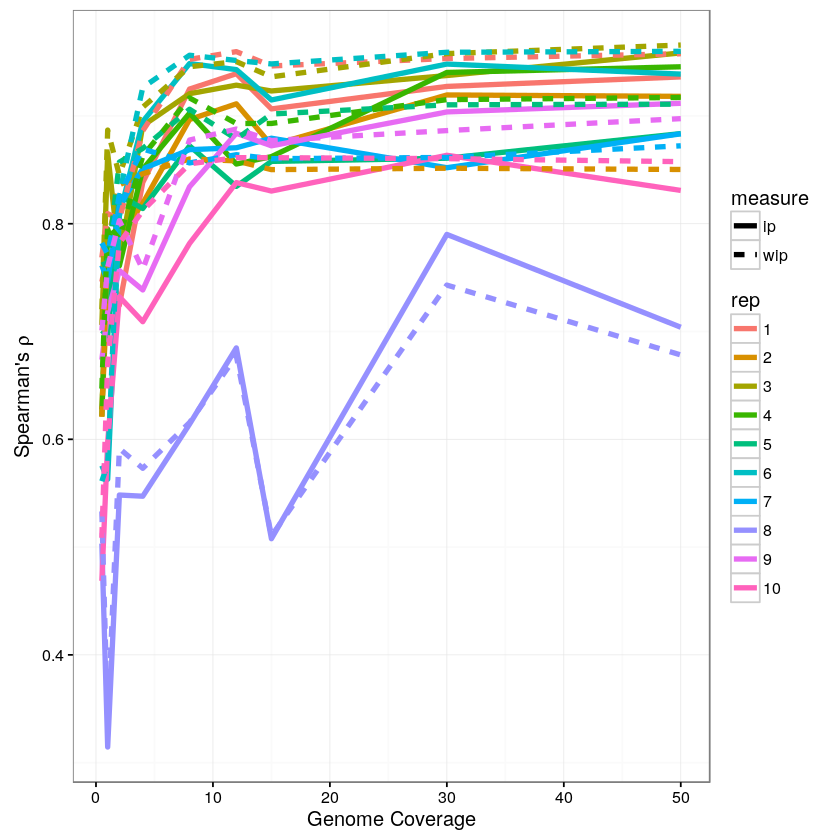

In [6]:
ggplot(coverage, aes(x=coverage, y=spearman, linetype=measure, color=rep)) +
    geom_line(aes(linetype=measure, color=rep),size=1.5) +
    xlab('Genome Coverage') +
    ylab(expression(paste("Spearman's ", rho))) +
    #scale_x_log10()+
    theme_bw() 

Here we summarise the replicates to averages $\pm$ SD. Note that we exclude replicate 8 as it is an outlier for both IP and WIP metrics (see above).

In [7]:
coverage = coverage[coverage$rep != 8,]
csumm = ddply(coverage, .(coverage, measure), summarise,
                spearman_m=mean(spearman),
                spearman_sd=sd(spearman))
summary(csumm)

    coverage     measure   spearman_m      spearman_sd     
 Min.   : 0.50   ip :9   Min.   :0.6535   Min.   :0.02625  
 1st Qu.: 2.00   wip:9   1st Qu.:0.7863   1st Qu.:0.03888  
 Median : 8.00           Median :0.8817   Median :0.04314  
 Mean   :13.61           Mean   :0.8374   Mean   :0.05329  
 3rd Qu.:15.00           3rd Qu.:0.9024   3rd Qu.:0.06005  
 Max.   :50.00           Max.   :0.9119   Max.   :0.09674  

You can see below that WIP marginally outperforms IP, at low coverage. Above about 20x, I would say that WIP and IP have equivalent performance.

The ribbon is 1 SD, so there is certainly no signficant difference.

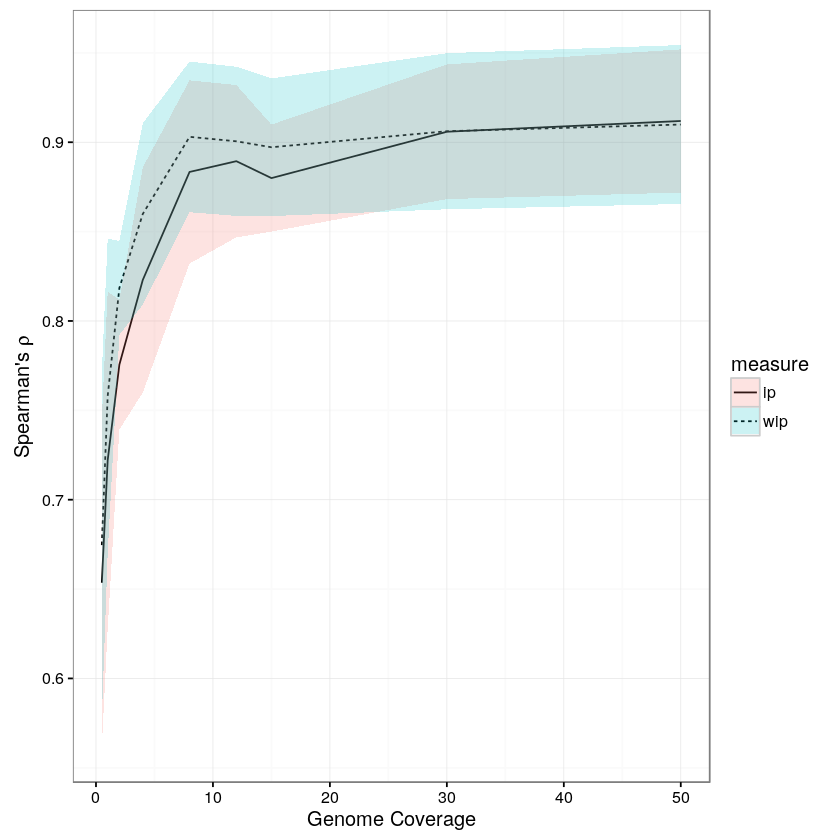

In [8]:
ggplot(csumm, aes(x=coverage, y=spearman_m, ymin=spearman_m-spearman_sd, ymax=spearman_m+spearman_sd, group=measure)) +
    geom_line(aes(linetype=measure)) +
    geom_ribbon(aes(fill=measure), alpha=0.2) +
    xlab('Genome Coverage') +
    ylab(expression(paste("Spearman's ", rho))) +
    #scale_x_log10()+
    theme_bw()

The differnce between WIP and IP is calculated here

In [9]:
cdiff = dcast(coverage, coverage * rep~ measure, value.var="spearman")
#cdiff = ddply(cdiff, .(coverage, rep), summarise, spearman_d=wip - ip)
cdiff = ddply(cdiff, .(coverage), summarise, diff_m=mean(wip - ip), diff_sd=sd(wip - ip))

summary(cdiff)

    coverage         diff_m             diff_sd       
 Min.   : 0.50   Min.   :-0.001986   Min.   :0.02256  
 1st Qu.: 2.00   1st Qu.: 0.011124   1st Qu.:0.02436  
 Median : 8.00   Median : 0.019634   Median :0.02872  
 Mean   :13.61   Mean   : 0.020349   Mean   :0.02780  
 3rd Qu.:15.00   3rd Qu.: 0.035914   3rd Qu.:0.03186  
 Max.   :50.00   Max.   : 0.042926   Max.   :0.03412  

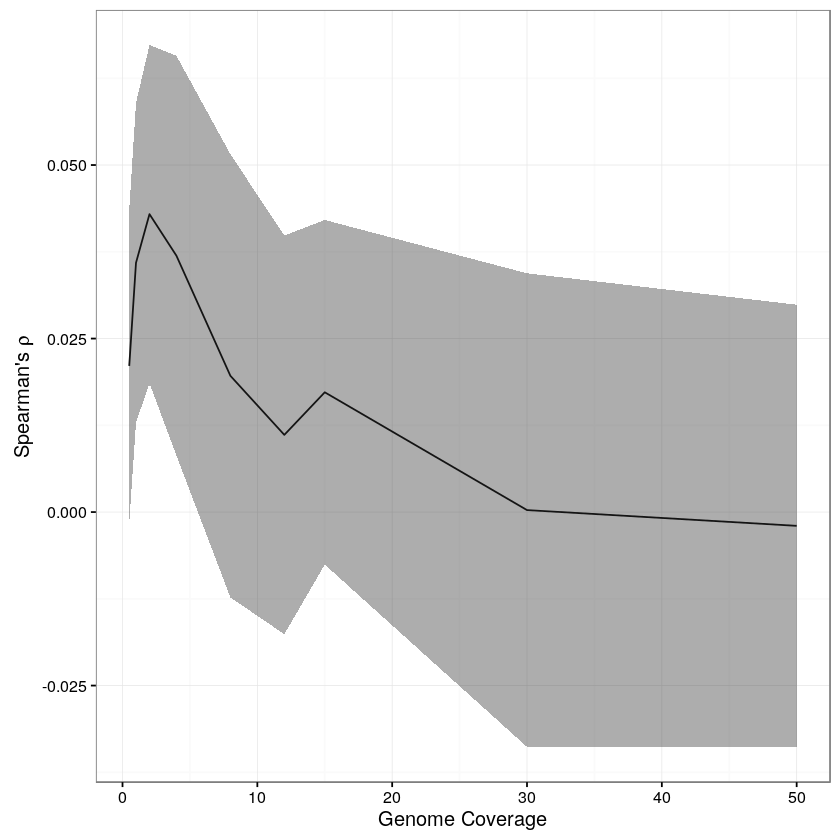

In [10]:
ggplot(cdiff, aes(x=coverage, y=diff_m, ymin=diff_m-diff_sd, ymax=diff_m+diff_sd)) +
    geom_line() +
    geom_ribbon(alpha=0.4) +
    xlab('Genome Coverage') +
    ylab(expression(paste("Spearman's ", rho))) +
    #scale_x_log10()+
    theme_bw() 

Scale vs $\rho$
---------------

Like coverage, we investigate the effect of variation at a constant coverage, in this case 30x. I also convert the scale into its inverse, as this is how some people prefer to think of it (i.e. one variant in X bases, as opposed to 0.0x variants per base on average. Each to their own...)

In [82]:
scale = stats[stats$coverage==30 & stats$scale <= 0.01,]
scale$var = as.factor(as.character(1/scale$scale))
scale$var = reorder(scale$var, 1/scale$scale, min)
scale$scale = 1/scale$scale
str(scale)

'data.frame':	60 obs. of  6 variables:
 $ coverage: num  30 30 30 30 30 30 30 30 30 30 ...
 $ measure : Factor w/ 2 levels "ip","wip": 2 2 2 1 1 1 2 2 2 1 ...
 $ scale   : num  1000 100 200 100 1000 200 1000 100 200 100 ...
 $ spearman: num  0.948 0.953 0.956 0.927 0.729 ...
 $ rep     : Factor w/ 10 levels "1","2","3","4",..: 1 1 1 1 1 1 2 2 2 2 ...
 $ var     : Factor w/ 3 levels "100","200","1000": 3 1 2 1 3 2 3 1 2 1 ...
  ..- attr(*, "scores")= num [1:3(1d)] 100 1000 200
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr  "100" "1000" "200"


In [83]:
ssumm = ddply(scale, .(measure, scale), summarise,
              sp_avg=mean(spearman),
              sp_max=(mean(spearman) + sd(spearman)),
              sp_min=(mean(spearman) - sd(spearman)))

pdf 
  2

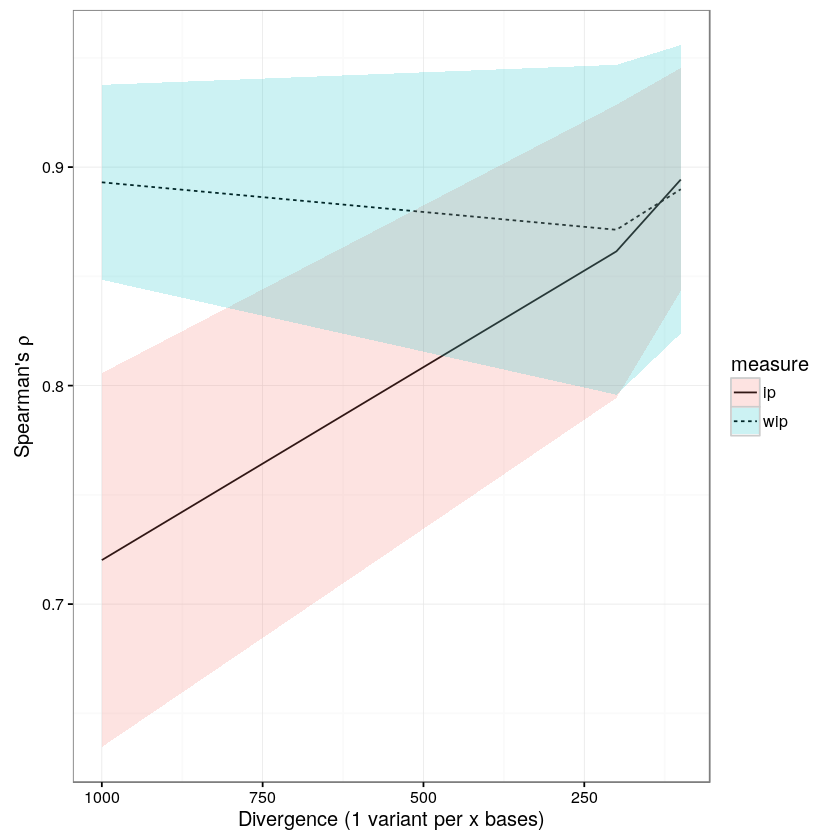

In [85]:
p = ggplot(ssumm, aes(x=scale,  y=sp_avg, ymin=sp_min, ymax=sp_max, group=measure)) +
    geom_line(aes(linetype=measure)) +
    geom_ribbon(aes(fill=measure), alpha=0.2) +
    xlab('Divergence (1 variant per x bases)') +
    ylab(expression(paste("Spearman's ", rho))) +
    #scale_x_log10() +
    scale_x_reverse() +
    theme_bw()
pdf("variation_vs_accuracy.pdf")
print(p)
dev.off()
p

Conclusions
-----------

- I think there might be an issue with the way I normalise trees. I think that we are probably at a higher level of divergence than I expect if we use the mean. I will do a run with a couple of reps using the maximum distance set to 1.0, i.e. that the entire tree scale is 0.5 (from root to tip, and then back again =1.0).
- I'd like to re-do the coverage sweep at a scale of 0.005 or 0.002 or even 0.001. I think that this might be more inline with our rice experiment. My take home from this is that WIP is only important when your signal:noise ratio is low, like when you have a small amount of variation. Otherwise, they are equivalent (neither is signficantly worse on average). Norman, can you comment?